In [87]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set3')
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})
import warnings
warnings.filterwarnings("ignore") # ignore plot warning messages
from ipywidgets import interact   # interactive plot
from scipy import stats, special # unpaired t-test, special function(Expit a.k.a. logistic sigmoid)

# Modeling
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_confusion_matrix
# import skopt
# import sys
# import os

In [88]:
# Import data
train = pd.read_csv("../input/trainwids2021/TrainingWiDS2021.csv", index_col=0)
test = pd.read_csv("../input/testwids2021/UnlabeledWiDS2021.csv", index_col=0)

print(train.shape)
print(test.shape)

train.head()

(130157, 180)
(10234, 179)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


# Target distribution

<AxesSubplot:xlabel='diabetes_mellitus', ylabel='count'>

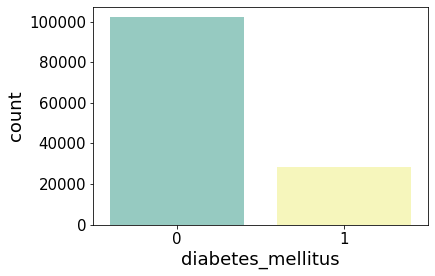

In [89]:
# Count targets
sns.countplot(train['diabetes_mellitus'])

* Unbalanced binary target distribution

## 1. Training data quality check

In [90]:
# Missing rows (just check, don't do anything yet)
prop_isnull = train.isnull().mean()
prop_isnull = prop_isnull[prop_isnull > 0]
prop_isnull[-10:]

d1_pao2fio2ratio_max    0.717126
d1_pao2fio2ratio_min    0.717126
h1_arterial_pco2_max    0.827201
h1_arterial_pco2_min    0.827201
h1_arterial_ph_max      0.828607
h1_arterial_ph_min      0.828607
h1_arterial_po2_max     0.825503
h1_arterial_po2_min     0.825503
h1_pao2fio2ratio_max    0.871232
h1_pao2fio2ratio_min    0.871232
dtype: float64

In [91]:
# Duplicated rows
train[train.duplicated() == True]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus


* 160 out of 180 columns have missing information, number of missing records ranging between 3.8 - 87.1%
* No duplicated rows

## 2. Distribution of Variables

In [92]:
# Data types
train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [93]:
# Separate data by binary, categorical, continous types

# Binary
two_unique_values = (train.nunique().values == 2) # find columns # unique value equals 2
binary = train.loc[:,two_unique_values] # select columns
binary = binary.loc[:, ~binary.isna().any()] # remove columns containing nulls

# Categorical & continuous
non_binaries = [col for col in train.columns if col not in binary.columns]
train_non_bi = train[non_binaries]
categoricals = train_non_bi.select_dtypes(include=["object"])
continuous = train_non_bi.select_dtypes(exclude=["object"])

print(binary.shape)
print(categoricals.shape)
print(continuous.shape)

(130157, 13)
(130157, 6)
(130157, 161)


## 2-1. Binary variables

In [94]:
# Missing data?
binary.isnull().mean()

elective_surgery               0.0
apache_post_operative          0.0
arf_apache                     0.0
intubated_apache               0.0
ventilated_apache              0.0
aids                           0.0
cirrhosis                      0.0
hepatic_failure                0.0
immunosuppression              0.0
leukemia                       0.0
lymphoma                       0.0
solid_tumor_with_metastasis    0.0
diabetes_mellitus              0.0
dtype: float64

* No missing rows

In [95]:
# Let's drop diabetes_mellitus from binary dataframe to separate features from their target
binary.drop('diabetes_mellitus', axis=1, inplace=True)
binary.shape

(130157, 12)

In [96]:
# Interactive plot to check distribution of binary variables
@interact(cols=binary.columns)
def get_countplot_binary(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.countplot(train[cols])
    
    # Print normalized counts of each variable
    print(binary[cols].value_counts(normalize=True).round(2))

interactive(children=(Dropdown(description='cols', options=('elective_surgery', 'apache_post_operative', 'arf_…

In [97]:
# Interactive plot to check relationships
# between the binary variables and the target variable
@interact(cols=binary.columns)
def get_countplot_diabetes(cols):
    plt.figure(figsize=(12,6))
    sns.countplot(x=cols, hue='diabetes_mellitus', data=train)
    plt.title(f'Diabetes mellitus (0, 1) and {cols}')
    plt.legend(bbox_to_anchor=(1.15, 1))
    
    # Print normalized counts of each variable
    print(train.groupby('diabetes_mellitus')[cols].value_counts(normalize=True).round(2))
    
    # This part is for categorical vaviables below
    # Rotate the xlabels if more than 4 values available
    if train[cols].nunique() > 4:
         plt.xticks(rotation=40)

interactive(children=(Dropdown(description='cols', options=('elective_surgery', 'apache_post_operative', 'arf_…

### Highlights of binary data

**arf_apache**
* When there was no diabetes: positive 2 %
* When there was diabetes: positive 6 %

<br>
* APACHE: Acute Physiology and Chronic Health Evaluation II score to predict hospital mortality

## 2-2. Categorical variables

In [98]:
# Missing data per each column
categoricals.isnull().mean()

ethnicity                0.012193
gender                   0.000507
hospital_admit_source    0.255061
icu_admit_source         0.001844
icu_stay_type            0.000000
icu_type                 0.000000
dtype: float64

* 25% of the observations lack their hospital_admit_source

In [99]:
# Interactive plot to check distribution of categorical variables
@interact(cols=categoricals.columns)
def get_countplot_cat(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.countplot(train[cols])
    
    # Rotate the xlabels if more than 4 values available
    if categoricals[cols].nunique() > 4:
         plt.xticks(rotation=40)
            
    # Print normalized counts of each variable
    print(categoricals[cols].value_counts(normalize=True).round(2))

interactive(children=(Dropdown(description='cols', options=('ethnicity', 'gender', 'hospital_admit_source', 'i…

### Highlights of categorical data

**Ethnity**
* Highly unbalanced ratial distribution: Majority of the data (~78%) is from Caucasians.

**Gender**
* Slightly more male samples(54%) than the females (46%)

**Hospital admit source**
* More than 52% from Emergercy Department. (25% of the patients lack this information)

**ICU admit source**
* Over 59% of patients admitted to ICU after Accident & Emergency

**ICU stay type**
* Most(95%) of the patients stay admitted to the unit, ~4% transferred to other locations, <1% readmitted

**ICU type**
* ~55% of the patients in Med-Surg ICU (=Medical Surgical Intensive Care Unit)

In [100]:
# Interactive plot to check relationships
# between the categorical variables and the target variable
interact(get_countplot_diabetes, cols=categoricals.columns)

interactive(children=(Dropdown(description='cols', options=('ethnicity', 'gender', 'hospital_admit_source', 'i…

<function __main__.get_countplot_diabetes(cols)>

**Ethnity**
* Regardless of ethnity, 20-30 % of the patients from the data had diabetes mellitus

**Gender**
* In both sexes, 21-22 % of the patiens had diabetes mellitus

**Hospital admit source, ICU admit source, ICU stay type, ICU type**
* Similar to ethnity, roughly 20-30 % of each group had diabetes mellitus

**icu_admit_source and icu_type**
* Slight changes in order of frequency when compared negative vs. positive to diabetes mellitus

## 2-3. Continuous variables

In [101]:
# Interactive plot to check distribution of continuous variables

# Excude ids from plot
except_ids = [col for col in continuous.columns if col[-2:] != 'id']

# Histograms to show distribution of continuous values
@interact(cols=except_ids)
def get_histplot(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.histplot(continuous[cols])
    
    plt.axvline(continuous[cols].median(), color='red')  # Median in red
    plt.axvline(continuous[cols].mean(), color='green')  # Mean in green
    
    print('Mean: ', round(continuous[cols].mean(), 1))
    print('Median: ', round(continuous[cols].median(), 1))

interactive(children=(Dropdown(description='cols', options=('age', 'bmi', 'height', 'pre_icu_los_days', 'readm…

In [102]:
# Interactive relplot between continuous variables and the target variable
@interact(cols=except_ids + ['diabetes_mellitus'])
def get_boxplot(cols):
    plt.figure(figsize=(12,6))
    sns.boxplot(x=train['diabetes_mellitus'], y=train[cols])
    plt.title(f'Diabetes mellitus (0, 1) and {cols}')
    
    # Print normalized counts of each variable
    count_diabetes = train.groupby('diabetes_mellitus')[cols].count()
    print('Total counts: ', count_diabetes.sum())
    print(' ')
    print(count_diabetes)
    print(' ')
    
    # Print mean values
    diabetes = train['diabetes_mellitus'] == 1
    positive = train[diabetes][cols]
    negative = train[~diabetes][cols]
    print('No diabetes meallitus(0)', negative.mean())
    print('Diabetes meallitus(1)', positive.mean())

interactive(children=(Dropdown(description='cols', options=('age', 'bmi', 'height', 'pre_icu_los_days', 'readm…

In [103]:
# Calculate ttest and print only the columns with significant difference
diabetes = train['diabetes_mellitus'] == 1
significant_cols = []

for col in continuous.columns:
    positive = continuous[diabetes][col]
    negative = continuous[~diabetes][col]
    tstats , p_value = stats.ttest_ind(negative.values, positive.values, nan_policy='omit')

    if p_value < 0.05:
        significant_cols.append(col)
        
print(len(significant_cols))
print(significant_cols[:15])

133
['age', 'bmi', 'icu_id', 'pre_icu_los_days', 'weight', 'albumin_apache', 'apache_3j_diagnosis', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache']


### Highlight of continous data

**Statistically significant difference between groups**
* 133 out of 161 columns including age, bmi, pre_icu_los_days, weight.

## 3. Data preprocessing + Feature engineering

In [104]:
train_new = train.copy()
test_new = test.copy()

print(train_new.shape)
print(test_new.shape)

(130157, 180)
(10234, 179)


In [105]:
# Sort by encounter_id and set it as an index

train_new = train_new.sort_values('encounter_id')
test_new = test_new.sort_values('encounter_id')

train_new.set_index('encounter_id', inplace=True)
test_new.set_index('encounter_id', inplace=True)

print(train_new.shape)
print(test_new.shape)
train_new.head()

(130157, 179)
(10234, 178)


,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
encounter_id,,,,,,,,,,,,,,,,,,,,,
147000,163,73.0,28.727377,1,Caucasian,M,182.90,NaN,Operating Room / Recovery,1082,...,NaN,NaN,0,0,0,0,0,0,0,0
147001,159,NaN,24.925526,0,Other/Unknown,M,162.60,NaN,Accident & Emergency,709,...,NaN,NaN,0,0,0,0,0,0,0,0
147002,40,43.0,25.118065,0,Caucasian,M,175.20,Emergency Department,Accident & Emergency,636,...,NaN,NaN,0,0,0,0,0,0,0,0
147003,202,35.0,24.838934,0,Caucasian,M,172.72,Emergency Department,Accident & Emergency,427,...,NaN,NaN,0,0,0,0,0,0,0,0
147004,171,59.0,24.389348,1,Other/Unknown,F,165.00,Operating Room,Operating Room / Recovery,404,...,NaN,NaN,0,0,0,0,0,0,1,0


In [106]:
@interact(col=train_new.columns)
def another_plot(col):
    plt.figure(figsize=(14,6))
    if col in continuous.columns:
        train_new.groupby('diabetes_mellitus')[col].hist()
    else:
        sns.countplot(x=col, hue='diabetes_mellitus', data=train_new)

interactive(children=(Dropdown(description='col', options=('hospital_id', 'age', 'bmi', 'elective_surgery', 'e…

* Type 2 diabetes is an adult-onset metabolic disease linked with excessive body weight, insufficient exercise
    * related columns: age, height-weight, bmi
    * ethnity (Excess body fat is associated with 30% of cases in Chinese and Japanese descent, 60–80% of cases in those of European and African descent, and 100% of Pima Indians and Pacific Islanders)

<br>

* High blood sugar level -> 'Hyperglycemia': an excessive amount of glucose circulates in the blood plasma.
    * glucose-apache, d1_glucose_max, d1_glucose_min

In [107]:
def fill_bmi(df):
    df['bmi'] = np.where(df['bmi'].isna(), df['weight']/ (df['height']/100)**2, df['bmi'])
    
fill_bmi(train_new)
fill_bmi(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 179)
(10234, 178)


In [108]:
# age >= 18 -> adult?
# bmi >= 30 -> obesity

def flag_obese_adult(df):
    df['obese_adult'] = pd.Series()
    adult = df['age'] >= 18
    obese = df['bmi'] >= 30
    df['obese_adult'] = df[adult & obese]['obese_adult'].apply(lambda x: 1)
#     df['obese_adult'].replace(np.nan, 0, inplace=True)

flag_obese_adult(train_new)
flag_obese_adult(test_new)

def metrics_obesity(df):
    df['bmi'] = df['bmi']**2
    df['obese_peril'] = df['age']**2 * df['bmi']
    df['height_weight_ratio'] = df['weight'] / df['height']
    

metrics_obesity(train_new)
metrics_obesity(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 182)
(10234, 181)


In [109]:
def after_first_hour(df):
    lab_col = [c for c in df.columns if((c.startswith("h1")) | (c.startswith("d1")))]
    lab_col_names = list(set(list(map(lambda i: i[ 3 : -4], lab_col))))
    
    first_h = []
    for v in lab_col_names:
        first_h.append(v+"_started_after_firstHour")
        df[v+"_d1_value_range"] = df[f"d1_{v}_max"].subtract(df[f"d1_{v}_min"])    
        df[v+"_h1_value_range"] = df[f"h1_{v}_max"].subtract(df[f"h1_{v}_min"])
        df[v+"_d1_h1_max_eq"] = (df[f"d1_{v}_max"] == df[f"h1_{v}_max"])*1
        df[v+"_d1_h1_min_eq"] = (df[f"d1_{v}_min"] == df[f"h1_{v}_min"])*1
        df[v+"_tot_change_value_range_normed"] = abs((df[v+"_d1_value_range"].div(df[v+"_h1_value_range"])))
        df[v+"_started_after_firstHour"] = ((df[f"h1_{v}_max"].isna()) & (df[f"h1_{v}_min"].isna())) & (~df[f"d1_{v}_max"].isna())
        df[v+"_day_more_extreme"] = ((df[f"d1_{v}_max"]>df[f"h1_{v}_max"]) | (df[f"d1_{v}_min"]<df[f"h1_{v}_min"]))
        df[v+"_day_more_extreme"].fillna(False)    

after_first_hour(train_new)
after_first_hour(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 406)
(10234, 405)


In [110]:
# Normal daily glucose level max: 7.8  min: 4 mmol/L
# (ref: https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html)
def metrics_glucose(df):
    df['glucose_apache'] = df['glucose_apache']
    df['d1_glucose_max'] = df['d1_glucose_max']
    df['d1_glucose_min'] = df['d1_glucose_min']
    df['d1_glucose_peril'] = df['d1_glucose_max'] / df['d1_glucose_min']
    
    high_glucose = df['d1_glucose_max'] > 7.8
    low_glucose = df['d1_glucose_min'] < 4
    df['glucose_imbalance'] = pd.Series()
    df['glucose_imbalance'] = df[high_glucose | low_glucose]['glucose_imbalance'].apply(lambda x:1)
    df['glucose_imbalance'] = df['glucose_imbalance'].fillna(0)

metrics_glucose(train_new)
metrics_glucose(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 408)
(10234, 407)


In [111]:
def metrics_renal(df):
    df['bun_apache'] = df['bun_apache']**2 
    df['creatinine_apache'] = df['creatinine_apache']**2 
    
    df['bun_creatinine'] = df['d1_bun_max'] * df['d1_creatinine_max']
    df['bun_creatinine_2'] = df['d1_bun_min'] * df['d1_creatinine_min']
    df['metrics_renal'] = df['bun_apache'] * df['creatinine_apache']
    df['arf_apache'] = df['arf_apache']**2   

metrics_renal(train_new)
metrics_renal(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 411)
(10234, 410)


In [112]:
def metrics_gcs(df):
    df['metrics_gcs'] = df['gcs_motor_apache'] * df['gcs_eyes_apache']
    df['gcs_verbal_apache'] = df['gcs_verbal_apache'].apply(lambda x: x*x)

metrics_gcs(train_new)
metrics_gcs(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 412)
(10234, 411)


In [113]:
def metrics_heart(df):    
    # Hemoglobin and diabetes: add wikipedia link
    df['metrics_hemoglobin'] = (df['d1_hemaglobin_max'] / df['d1_hemaglobin_min'])
    
    mbp = [f for f in df.columns if f[3:6] == 'mbp']
    df['metrics_mbp'] = df[mbp].sum(axis=1)
    
    sysbp = [f for f in df.columns if f[3:8] == 'sysbp']
    df['metrics_sysbp'] = df[sysbp].sum(axis=1)
    df['d1_sysbp_max_2'] = df['d1_sysbp_max'].apply(lambda x: x*x)

    diasbp = [f for f in df.columns if f[3:9] == 'diasbp']
    df['metrics_diasbp'] = df[diasbp].sum(axis=1)
    
    df["d1_resprate_div_mbp_min"] = df["d1_resprate_min"] / df["d1_mbp_min"]
    df["d1_resprate_div_sysbp_min"] = df["d1_resprate_min"] / df["d1_sysbp_min"]
    
    # In hypertensive diabetes mellitus, lower K & lower Ca & higher Na can be observed
    # https://pubmed.ncbi.nlm.nih.gov/18488152/
    # Hypertension: systolic > 129 mmHg or diastolic > 79 mmHg
    d1_systolic_avg = df[['d1_sysbp_max', 'd1_sysbp_min']].mean(axis=1) > 129
    d1_diastolic_avg = df[['d1_diasbp_max', 'd1_diasbp_min']].mean(axis=1) > 79
    hypertensive = [d1_systolic_avg | d1_diastolic_avg]
    df['hypertensive'] = hypertensive[0]*1
    
    df['metrics_ions_max'] = df['d1_calcium_max']+df['d1_potassium_max']
    df['metrics_ions_max'].replace(np.nan, df['metrics_ions_max'].mean(), inplace=True)
    df['metrics_ions_min'] = df['d1_calcium_min']+df['d1_potassium_min']
    df['metrics_ions_min'].replace(np.nan, df['metrics_ions_min'].mean(), inplace=True)

metrics_heart(train_new)
metrics_heart(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 422)
(10234, 421)


In [122]:
def possible_dka(df):
# diabetic ketoacidosis (DKA): disturbance of the mechanisms to maintain blood pH
# an acute and life-threatening complication of the chronic metabolic disease
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC151994/

# normal anion gap: Na+ – (Cl– + HCO3–) = 12 mmol/L
# In DKA, anion gap increased & the sum of bicarbonate and chloride concentrations is reduced
    df['metrics_sodium'] = df[['d1_sodium_max', 'd1_sodium_min']].mean(axis=1)
    df['metrics_hco3'] = df[['d1_hco3_max', 'd1_hco3_min']].mean(axis=1)

# Increased potassium, lactate
    df['metrics_potassium'] = df[['d1_potassium_max', 'd1_potassium_min']].mean(axis=1)
    df['metrics_lactate'] = df[['d1_lactate_max', 'd1_lactate_min']].mean(axis=1)

# Also, arterial pH reduces (<=7.30)
    acidic_blood_gas = (df[['d1_arterial_ph_max', 'd1_arterial_ph_min']].mean(axis=1) <= 7.30)
    df['arterial_pH_low'] = acidic_blood_gas*1


possible_dka(train_new)
possible_dka(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 427)
(10234, 426)


In [123]:
def metrics_liver(df):
    df['metrics_liver'] = df['cirrhosis'].fillna(0) * df['hepatic_failure'].fillna(0)

metrics_liver(train_new)
metrics_liver(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 428)
(10234, 427)


In [124]:
def metrics_immune(df):
    df['wbc_apache'] = df['wbc_apache']**2
    immune_cols = ['wbc_apache', 'immunosuppression', 'leukemia', 'lymphoma']
    df['metrics_immune'] = df[immune_cols].fillna(0).sum(axis=1)
    
metrics_immune(train_new)
metrics_immune(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 429)
(10234, 428)


In [125]:
# 
train_new['pre_icu_los_days'] = train_new['pre_icu_los_days']**2
test_new['pre_icu_los_days']  = test_new['pre_icu_los_days']**2

print(train_new.shape)
print(test_new.shape)

(130157, 429)
(10234, 428)


In [126]:
# Let's drop some columns of which the majority are empty rows
# First, examine the proportion of empty values of each column
prop_nulls = train_new.isnull().mean()
prop_nulls[-30:]

potassium_d1_value_range                   0.096391
potassium_h1_value_range                   0.774611
potassium_d1_h1_max_eq                     0.000000
potassium_d1_h1_min_eq                     0.000000
potassium_tot_change_value_range_normed    0.805942
potassium_started_after_firstHour          0.000000
potassium_day_more_extreme                 0.000000
d1_glucose_peril                           0.063331
glucose_imbalance                          0.000000
bun_creatinine                             0.107409
bun_creatinine_2                           0.107409
metrics_renal                              0.196901
metrics_gcs                                0.016826
metrics_hemoglobin                         0.124711
metrics_mbp                                0.000000
metrics_sysbp                              0.000000
d1_sysbp_max_2                             0.002082
metrics_diasbp                             0.000000
d1_resprate_div_mbp_min                    0.006269
d1_resprate_

In [127]:
# Let's say we drop the entire rows of columns of which >60% are empty
# since those will be hard to be imputed in the future
less_than_40perc = prop_nulls[prop_nulls <= 0.40]
cols_to_keep = list(less_than_40perc.index)

common_cols = [c for c in cols_to_keep if (c in test_new.columns) and (c in train_new.columns)]
common_cols

train_new = train_new[common_cols+['diabetes_mellitus']]
test_new = test_new[common_cols]

print(train_new.shape)
print(test_new.shape)

(130157, 298)
(10234, 297)


In [128]:
# Convert string (categorical) values into numbers using dummies
train_new = pd.get_dummies(train_new, drop_first=True, dtype='int64')
test_new = pd.get_dummies(test_new, drop_first=True, dtype='int64')
print(train_new.shape)
print(test_new.shape)

(130157, 325)
(10234, 319)


# 4. Modelling

In [129]:
cols_to_remove = ['readmission_status', 'hospital_id']

# Split the data into train and test sets for supervised learning.
# Define features and the target

final_features = [c for c in test_new.columns if (c in train_new.columns) and (c not in cols_to_remove)]
target = 'diabetes_mellitus'

train_df = train_new[final_features + [target]]
test_df = test_new[final_features]

print(train_df.shape)
print(test_df.shape)

(130157, 318)
(10234, 317)


In [130]:
param = {
        'learning_rate': 0.009,
        'feature_fraction': 0.2,
        'lambda_l1': 2,
        'lambda_l2': 1,
        'subsample': 1,
        'max_depth': -1,
        'scale_pos_weight': 4,
        'n_estimators': 10000,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'boost_from_average': False,
        'force_col_wise': True
    }

In [131]:
%%time
nfold = 4

predictors = final_features

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=201)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

i = 1
for train_index, valid_index in skf.split(train_df, train_df[target].values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(train_df.iloc[train_index][predictors].values,
                           label=train_df.iloc[train_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train_df.iloc[valid_index][predictors].values,
                           label=train_df.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param, xg_train, valid_sets = [xg_valid], verbose_eval=500, early_stopping_rounds = 500)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test_df[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.4f}".format(roc_auc_score(train_df[target].values, oof)))


fold 1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21113, number of negative: 76504
[LightGBM] [Info] Total Bins 23039
[LightGBM] [Info] Number of data points in the train set: 97617, number of used features: 315
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.851706
[1000]	valid_0's auc: 0.863068
[1500]	valid_0's auc: 0.866248
[2000]	valid_0's auc: 0.867674
[2500]	valid_0's auc: 0.868262
[3000]	valid_0's auc: 0.86863
[3500]	valid_0's auc: 0.8689
[4000]	valid_0's auc: 0.869089
[4500]	valid_0's auc: 0.869204
[5000]	valid_0's auc: 0.86928
Early stopping, best iteration is:
[4862]	valid_0's auc: 0.869313

fold 2
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21114, number of negative: 76504
[LightGBM] [Info] Total Bins 23008
[Ligh

In [ ]:
break

# 5. Predict and Submit

In [ ]:
template = pd.read_csv("../input/solutiontemplatewids2021/SolutionTemplateWiDS2021.csv")
template = template.sort_values('encounter_id')
print(template.shape)
template.head()

In [ ]:
template['diabetes_mellitus'] = predictions
print(template.isnull().sum())
template.head()

In [ ]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Diabetes Mellitus Predictions 66.csv'
template.to_csv(filename, index=False)